# Практическое задание 3
# I. Разложение ошибки на смещение и разброс
### Задача 1

ID посылки с кодом - 9968309
Всего выполнено задач на 11.5 баллов

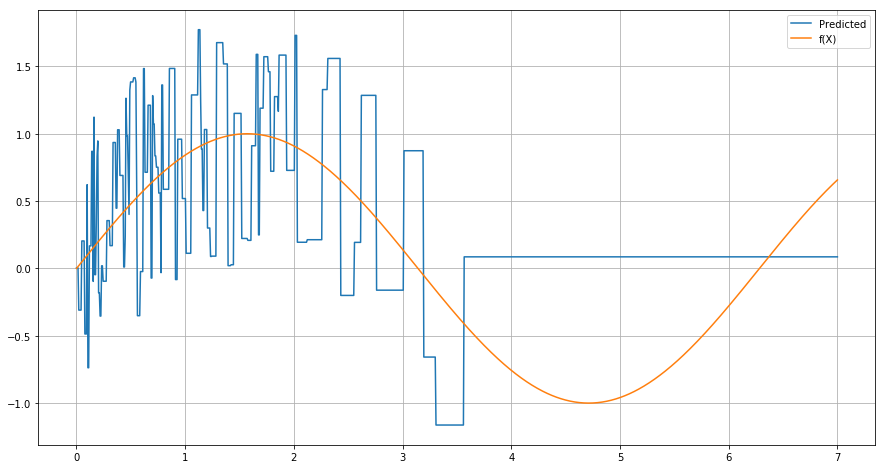

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeRegressor
#import seaborn as sns; sns.set()
from matplotlib.colors import ListedColormap
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm
import pandas as pd
from IPython.display import display, HTML

#my_cmap = ListedColormap(sns.color_palette("bright").as_hex())


def f(x):
    return np.sin(x)   # истинная зависимость в данных

sample_size = 100      # длина выборки
samples_num = 20       # количество выборок
linspace = np.linspace(0, 7, 1000)  # точки для построения графиков


X = np.random.exponential(size=sample_size)  # генерируем выборку

y = f(X) + np.random.uniform(low=-1.0, high=1.0, size=sample_size) # генерируем целевой вектор

clf = DecisionTreeRegressor()
clf.fit(X[:, np.newaxis], y)
y_pred = clf.predict(linspace[:, np.newaxis])


plt.figure(figsize=(15,8))

plt.plot(linspace, y_pred, label='Predicted')
plt.plot(linspace, f(linspace), label='f(X)')
plt.grid(True)
plt.legend()
plt.show()

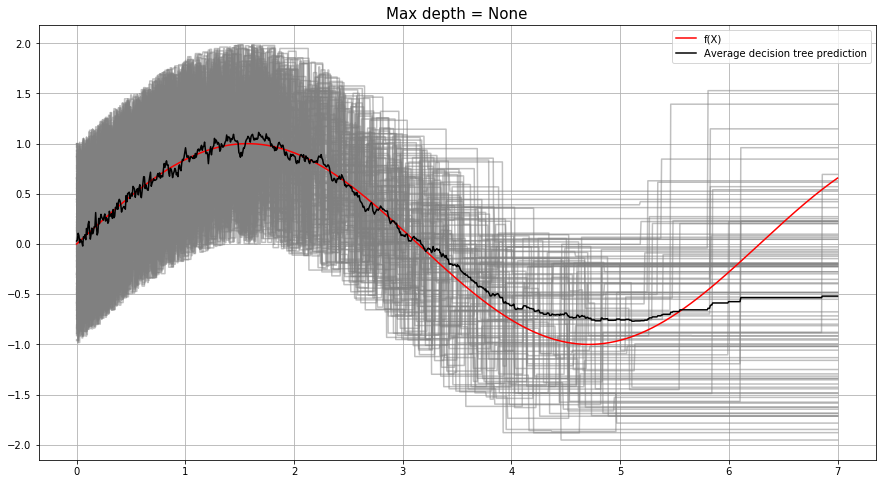

In [14]:
# Повторим sample_size раз первые 3 шага и посмотрим как они восстанавливают зависимость
def draw_tree(max_depth=None):
    plt.figure(figsize=(15, 8))

    y_pred_all = []
    for i in range(sample_size):
        X = np.random.exponential(size=sample_size)  # генерируем выборку

        y = np.random.uniform(low=-1.0, high=1.0, size=sample_size) + f(X)# генерируем целевой вектор с шумом

        # создаем дерево нужной глубины
        clf = DecisionTreeRegressor(max_depth=max_depth)
        #обучаем его
        clf.fit(X[:, np.newaxis], y)
        #делаем предикт на отрезке, созданном ранее
        y_pred = clf.predict(linspace[:, np.newaxis])
        y_pred_all.append(y_pred)
        plt.plot(linspace, y_pred, color='gray', alpha=0.5)

    #теперь посчиатем среднее всех предсказаний
    average_y_pred = np.mean(y_pred_all, axis=0)
    plt.plot(linspace, f(linspace), color='red', label='f(X)')
    plt.title('Max depth = {}'.format(max_depth), size=15)
    plt.plot(linspace, average_y_pred, color='black', label='Average decision tree prediction')
    plt.legend()
    plt.grid(True)

    plt.show()
    

draw_tree()

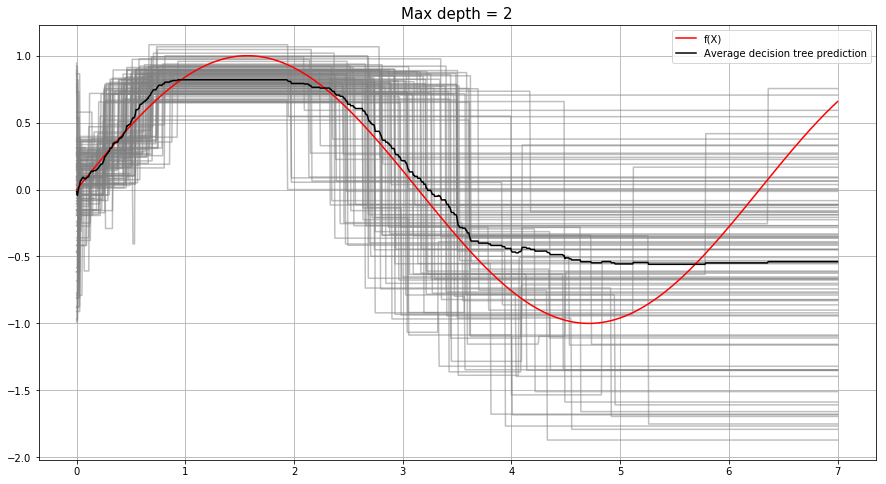

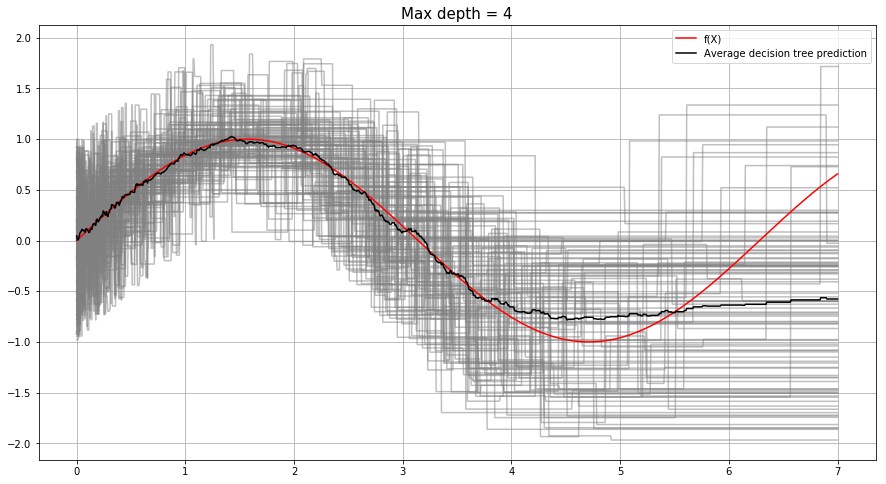

In [3]:
draw_tree(2)
draw_tree(4)

Думаю, вполне очевидно, что как в случае с ограничением глубины до 4, так и в случае без ограничения глубины смещение близко к нулю, однако без ограничения глубины мы также получаем некоторый разброс.

### Задача 2. Приближенное оценивание смещения и разброса

In [24]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor


regressors = [LinearRegression(), 
              DecisionTreeRegressor(), 
              RandomForestRegressor(),
              GradientBoostingRegressor()]
generators = [lambda size: np.random.normal(0, 0.3, size=size),
              lambda size: np.random.exponential(0.3, size=size),
              lambda size: np.random.uniform(-1, 1, size=size),
              lambda size: np.random.uniform(0, 1, size=size)]


df_bias = pd.DataFrame(columns=["normal(0, 0.3)", "exponential(0.3)", "uniform(-1, 1)", "uniform(0, 1)"],
                       index=["LinearRegression", "DecisionTree", "RandomForest", "GradientBoosting"])
df_variance = pd.DataFrame(columns=df_bias.columns, index=df_bias.index)


In [25]:
from importlib import reload
import hw3code

reload(hw3code)

<module 'hw3code' from '/home/maga/homework-MO/3/hw3code.py'>

In [174]:
# анализируем и тд
def f(x):
    return 5 * np.sin(10 * x)

for id_i, reg in enumerate(regressors):
    for id_j, gen in tqdm(enumerate(generators)):
        bias, variance = hw3code.compute_bias_variance(reg, f, gen, gen)
        df_bias.iloc[id_i][id_j] = bias
        df_variance.iloc[id_i][id_j] = variance

display(df_variance)
display(df_bias)

4it [00:00,  7.56it/s]
4it [00:00,  5.28it/s]
4it [00:12,  3.00s/it]
4it [00:19,  4.94s/it]


,"normal(0, 0.3)",exponential(0.3),"uniform(-1, 1)","uniform(0, 1)"
LinearRegression,0.0858639,0.0767993,0.0756079,0.05797
DecisionTree,0.171391,0.229553,0.360477,0.0900397
RandomForest,0.0972887,0.133229,0.195702,0.0486984
GradientBoosting,0.1136,0.162136,0.143824,0.0394338


,"normal(0, 0.3)",exponential(0.3),"uniform(-1, 1)","uniform(0, 1)"
LinearRegression,12.1799,7.09644,11.7468,12.0447
DecisionTree,0.0751522,0.0896026,0.00219314,0.000615519
RandomForest,0.0846484,0.134268,0.00210787,0.000736001
GradientBoosting,0.0763373,0.0932497,0.0125,0.0012936


Итак, отранжируем алгоритмы в порядке увеличения разброса:
1. Linear regression
2. Random Forest, Gradient Boosting (RF имеет лучшие показатели на экспоненциальном и нормальном распределении, а GB на равномерном)
3. Decision tree

Для начала заметим, что на 1ом месте стоит линейная регрессия, которая по сути вообще не работает на нашей выборке, ведь мы имеем нелинейную зависимость от признака (sin). Тем не менее, учитывая то, как именно считается разброс, несложно понять, как она попала на 1ое место.

Как и ожидалось, случайный лес сильно уменьшает разброс относительно решающего дерева за счет усреднения ответов. Бустинг же направлен на понижение смещения, разброс при этом либо остается таким же, либо увеличивается. Интересно заметить, что на равномерном распределении градиентный бустинг показал меньший разброс, чем случайный лес.

Также очевидна зависимость ошибки от вероятностной модели. Так, например, уменьшая длину интервала возможных значений для равномерного распределения c [-1; 1] до [0; 1], мы получаем немалое уменьшение разброса, но практические сохраняем то же смещение, т.к отдаление от правильного ответа по прежнему будет лежать в пределах единицы. Также учитывая свойства нормального распределения при данных параметрах вполне очевидно, почему его разброс меньше, чем у равномерного при [-1;1], но при этом выше, чем у равномерного  с [0;1] (достаточно будет построить гистрограмму этих распределений, чтобы наблюдать разброс значений - у нормального все значения будут лежать примерно от -1.2 до 1.2, но по большей части сосредоточенные в точке математического ожидания).

1. Linear regression
2. Random Forest, Gradient Boosting (RF имеет лучшие показатели на экспоненциальном и нормальном распределении, а GB на равномерном)
3. Decision tree

Лучшие показатели по разбросу показала линейная регрессия, т.к ее предсказания всегда лежат на одной прямой (тем не менее это не значит, что она хорошо работает здесь, достаточно взглянуть на ее смещение). Далее идет случайный лес, уменьшающий разброс за счет усреднения предсказаний композиций деревьев и далее стоит градиентный бустинг, с немного большим разбросом, однако лучшим смещением, что закономерно. Тем не менее на равномерном распределении можно наблюдать интересную ситуацию: разброс случайного леса стал больше чем у градиента, а смещение градиента наоборот увеличилось и превысило первое для леса.

Очевидно, что вероятностное распределение влияет на дисперсию и мат ожидание ошибки. Увеличивая интервал значений для равномерного распределения мы получаем и увеличение разброса, а уменьшая дисперсию для нормального распределения мы уменьшаем разброс, что вполне очевидно. 

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

def draw_plot(gen):
    fig, ax = plt.subplots(3, 4, figsize=(15, 10))
    fig.tight_layout()
    for idx, reg in enumerate(regressors):
        for idy, param in tqdm(enumerate(['sample_size', 'samples_num', 'objects_num'])):
            bias_variance = []
            # варьируем значение, переданное как параметр, остальные оставляем стандартными
            # в качестве генератора шума и выборки возьмем нормальное распределение
            for i in range(100, 1000, 10):
                bias_variance.append(hw3code.compute_bias_variance(reg, f, gen, gen, **{ param : i}))

            bias_variance = np.array(bias_variance)

            # так как нам важны не абсолютные значения, а динамика роста
            # нормализуем все значения, чтобы уместить их на 1 график, не потеряв масштаба
            bias = scaler.fit_transform(bias_variance[:, 0][:, np.newaxis]).flatten()
            variance = scaler.fit_transform(bias_variance[:, 1][:, np.newaxis]).flatten()
    
            # ставим название только для самого верхнего графика
            if idy == 0:
                ax[idy, idx].set_title(df_bias.index[idx])

            ax[idy, idx].plot([i for i in range(100, 1000, 10)], bias, label='Bias')
            ax[idy, idx].plot([i for i in range(100, 1000, 10)], variance, label='Variance')
            # берем название регрессора из индексов созданной ранее таблицы
            
            ax[idy, idx].set_xlabel('{}'.format(param))
            ax[idy, idx].grid(True)
            ax[idy, idx].set_yticks(())
            ax[idy, idx].set_xticks(())
            ax[idy, idx].legend()
    
    plt.show()

3it [00:37, 12.66s/it]
3it [00:55, 18.44s/it]
3it [17:14, 344.77s/it]
3it [27:36, 552.19s/it]


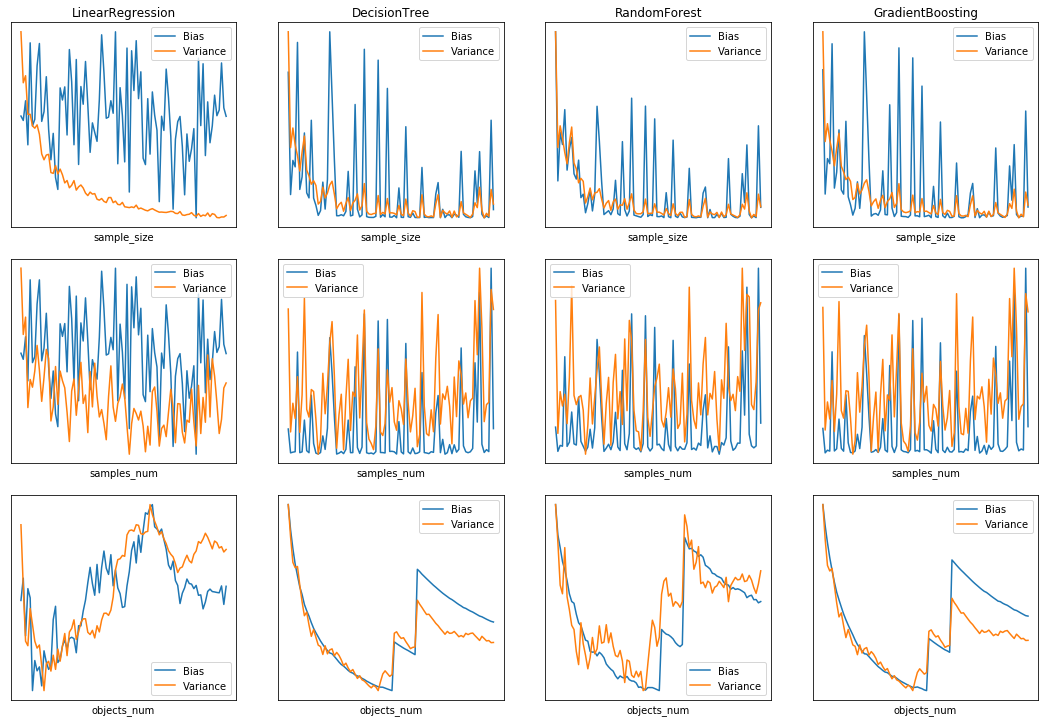

In [8]:
# нарисуем графики для нормального распределения с параметрами (0, 0.3)
draw_plot(generators[0])

3it [00:36, 12.01s/it]
3it [00:53, 17.75s/it]
3it [16:56, 338.94s/it]
3it [27:44, 554.73s/it]


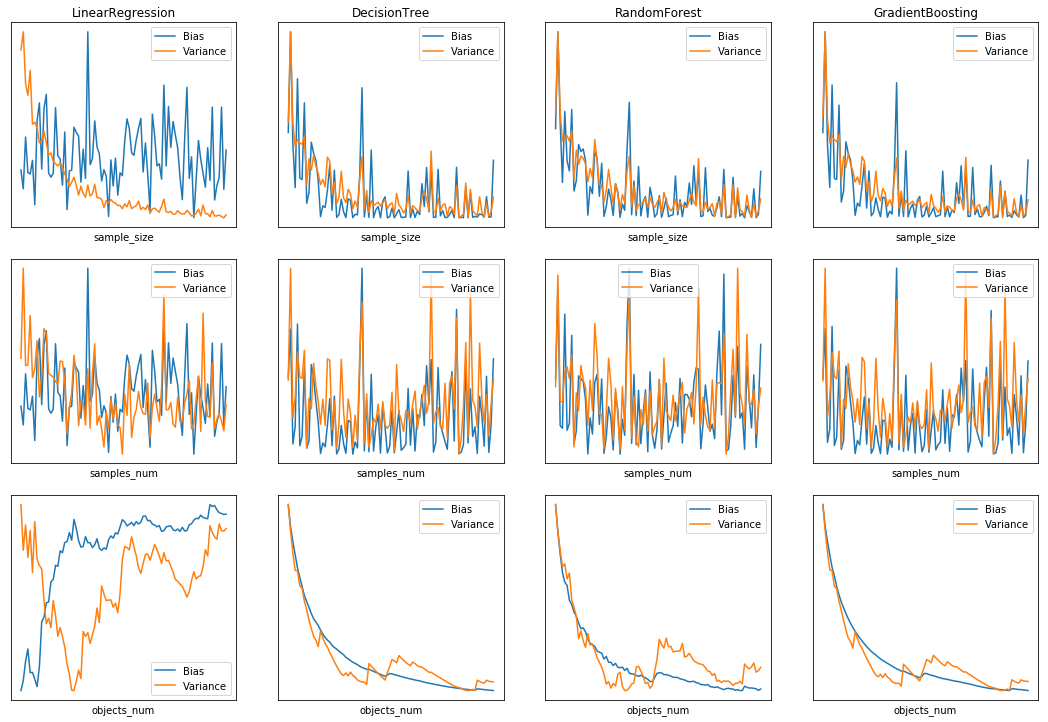

In [9]:
# нарисуем графики для экспоненциального распределения с параметром (0.3)
draw_plot(generators[1])

3it [00:33, 11.29s/it]
3it [00:51, 17.01s/it]
3it [16:59, 339.81s/it]
3it [27:51, 557.24s/it]


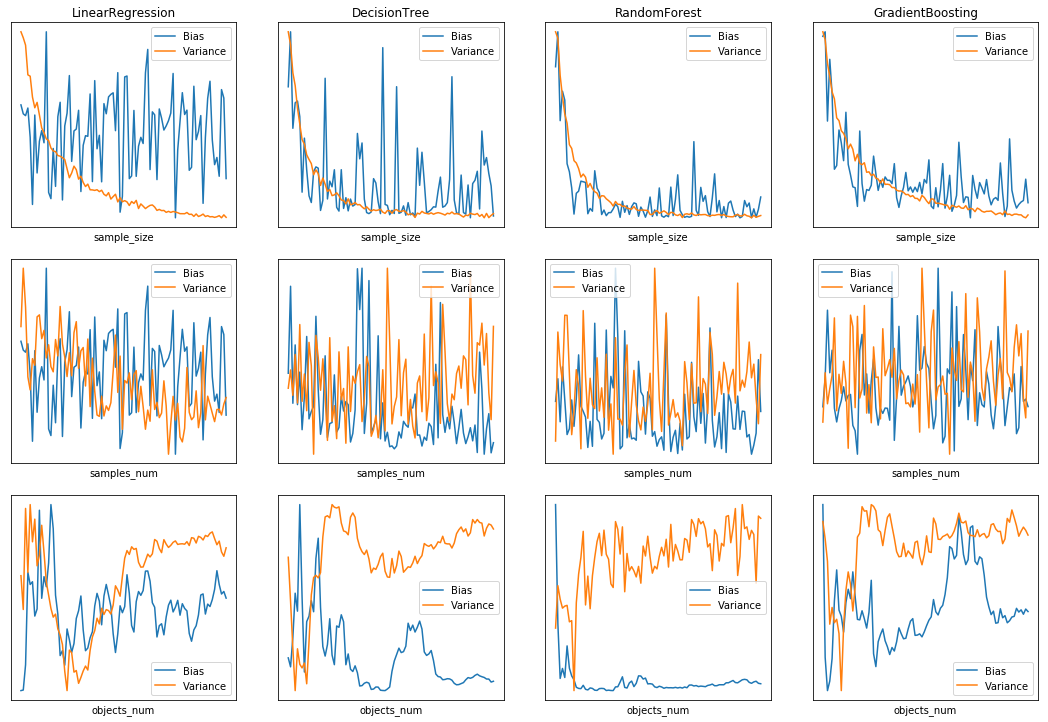

In [10]:
# нарисуем графики для равномерного распределения с параметрами (-1, 1)
draw_plot(generators[2])

3it [00:32, 10.98s/it]
3it [00:50, 16.75s/it]
3it [16:48, 336.11s/it]
3it [27:34, 551.36s/it]


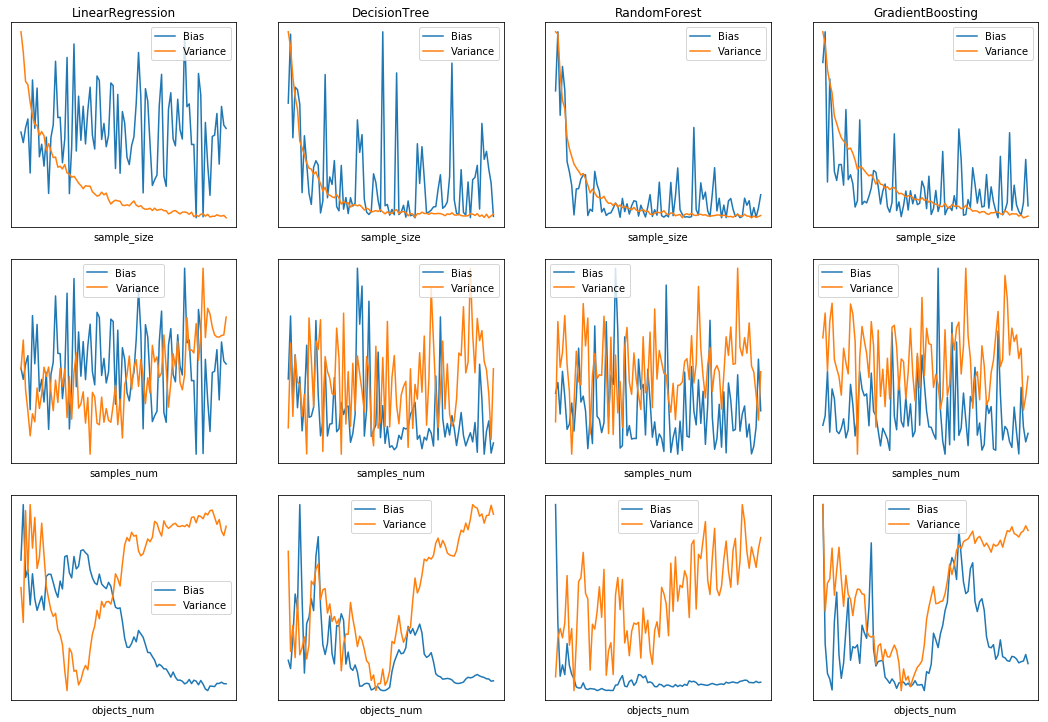

In [11]:
# нарисуем графики для нормального распределения с параметрами (0, 1)
draw_plot(generators[3])

Из построенных графиков можно однозначно сказать, что увеличение параметра sample_size уменьшает разброс на всех распределениях. Также заметно неоднозначное изменение разброса при увеличении objects_num: до какого-то порога идет уменьшение, а затем снова увеличение; в случае смещения ситуация схожа, однако на равномерном распределении увеличение параметра в большинстве случаев только уменьшает его. Изменение samples_num на разброс никак не влияет.

## II. Решающие деревья своими руками
### Задача 3.

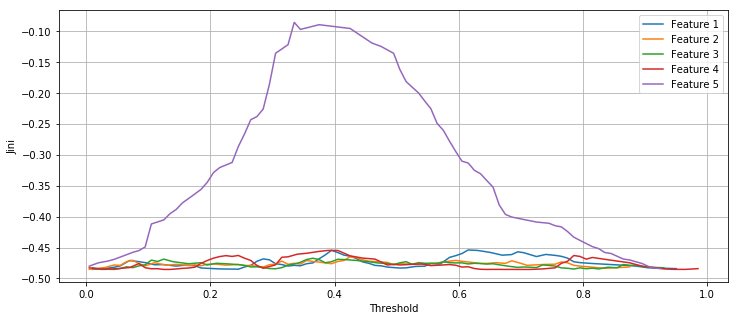

In [161]:
students_data = pd.read_csv('students.csv')

plt.figure(figsize=(12, 5))

for i in range(5):
    # считаем индексы джини/пороги для каждого столбца
    thresholds, jinis, b_threshold, best_jini = hw3code.find_best_split(students_data.iloc[:, i], students_data.iloc[:, 5])
    plt.plot(thresholds, jinis, label='Feature {}'.format(i + 1))
    
plt.xlabel('Threshold')
plt.ylabel('Jini')
plt.legend()
plt.grid(True)
plt.show()

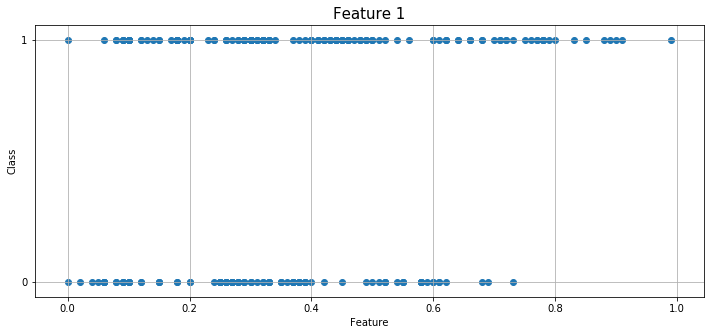

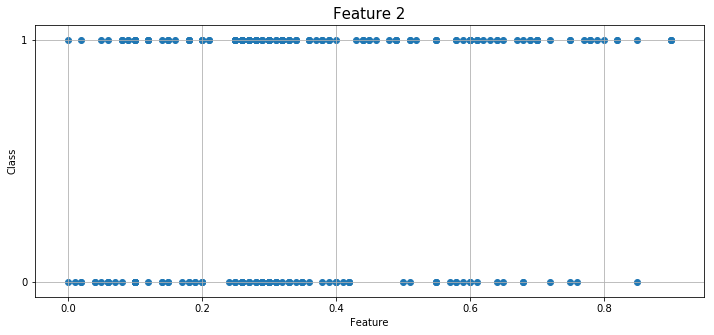

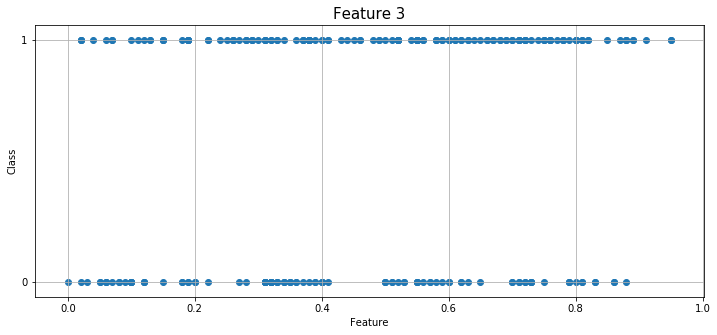

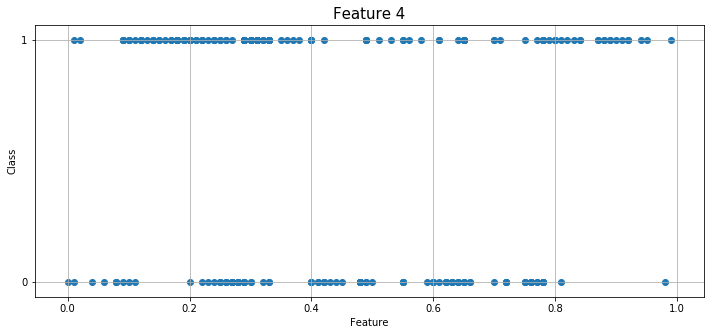

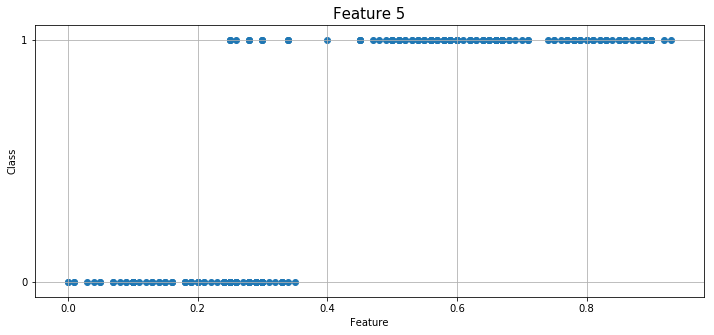

In [89]:
for i in range(5):
    plt.figure(figsize=(12, 5))
    plt.scatter(students_data.iloc[:, i], students_data.iloc[:, 5])
    plt.title('Feature {}'.format(i + 1), size=15)
    plt.xlabel('Feature')
    plt.ylabel('Class')
    plt.yticks((0, 1))
    plt.grid(True)

plt.show()

Из полученных графиков очевидно, что наилучшее деление будет произведено по 5му признаку в районе порога 0.4, что полностью соответствует графику, полученному ранее. Очевидно, что кривая Джини для "хороших" признаков имеет четкий минимум в районе хорошего порога, в то время как для "плохих", кривую можно приблизить константой, т.к она представляет из себя практичеки прямую линию.

In [121]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
import hw3code
reload(hw3code)


# загрузим датасет mushrooms
mushrooms = pd.read_csv('agaricus-lepiota.data', header=None)

le = LabelEncoder()
# закодируем все признаки
target = le.fit_transform(mushrooms.as_matrix()[:, 0])
train_data = mushrooms.as_matrix()[:, 1:]

for i in range(train_data.shape[1]):
    train_data[:, i] = le.fit_transform(train_data[:, i])

# делим выборку на обучающую и тестовую
X_train1, X_test1, y_train1, y_test1 = train_test_split(train_data, target, test_size=0.5)

In [175]:
# объявим все признаки вещественными
custom_tree = hw3code.DecisionTree(['categorical' for i in range(len(target))])

custom_tree.fit(X_train1, y_train1)

# проверим точность предсказывания
print (accuracy_score(y_test1, custom_tree.predict(X_test1)))

1.0


Получили нужное значение.

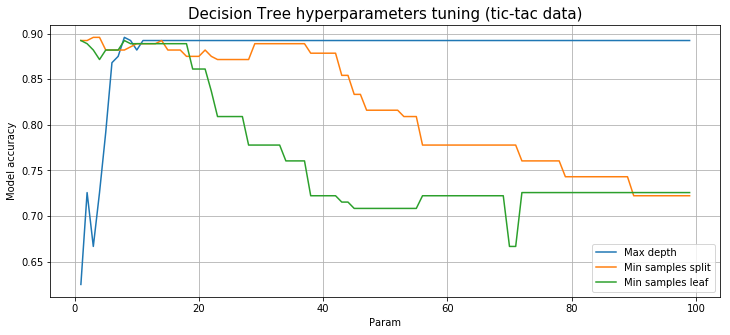

In [186]:
import hw3code
reload(hw3code)

# загружаем и обрабатываем выборку tic-tac
tic_tac = pd.read_csv('tic-tac.data', header=None)
target_tic_tac = le.fit_transform(tic_tac.as_matrix()[:, 9])
train_data_tic_tac = tic_tac.as_matrix()[:, :9]

for i in range(train_data_tic_tac.shape[1]):
    train_data_tic_tac[:, i] = le.fit_transform(train_data_tic_tac[:, i])
    
X_train4, X_test4, y_train4, y_test4 = train_test_split(train_data_tic_tac, target_tic_tac, test_size=0.3)

plt.figure(figsize=(12, 5))

results1 = []
results2 = []
results3 = []

for i in range(1, 100):
    clf = hw3code.DecisionTree(['categorical']*10, max_depth=i)
    clf.fit(X_train4, y_train4)
    results1.append(accuracy_score(y_test4, clf.predict(X_test4)))

    clf = hw3code.DecisionTree(['categorical']*10, min_samples_split=i)
    clf.fit(X_train4, y_train4)
    results2.append(accuracy_score(y_test4, clf.predict(X_test4)))
    
    clf = hw3code.DecisionTree(['categorical']*10, min_samples_leaf=i)
    clf.fit(X_train4, y_train4)
    results3.append(accuracy_score(y_test4, clf.predict(X_test4)))
    
plt.plot(np.arange(1, 100), results1, label='Max depth')
plt.plot(np.arange(1, 100), results2, label='Min samples split')
plt.plot(np.arange(1, 100), results3, label='Min samples leaf')

plt.title('Decision Tree hyperparameters tuning (tic-tac data)', size=15)
plt.ylabel('Model accuracy')
plt.xlabel('Param')
plt.grid(True)
plt.legend()
plt.show()

In [122]:
# загрузим все наборы данных и обработаем
df_accuracy = pd.DataFrame(columns=["Real", "Categorical", "Real + OHE", "Sklearn Tree"],
                       index=["Mushrooms", "tic-tac-toe", "Cars", "Nursery"])

# выборки mushrooms и tic-tac мы уже загрузили и обработали
datasets = [(train_data, target), (train_data_tic_tac, target_tic_tac)]

# загружаем и обрабатываем выборку car
cars = pd.read_csv('car.data', header=None)
target_cars = cars.as_matrix()[:, 6]
target_cars[target_cars == 'unacc'] = 0
target_cars[target_cars == 'acc'] = 0
target_cars[target_cars != 0] = 1

train_data_cars = cars.as_matrix()[:, :6]

for i in range(train_data_cars.shape[1]):
    train_data_cars[:, i] = le.fit_transform(train_data_cars[:, i])
    
datasets.append((train_data_cars, target_cars))

# загружаем и обрабатываем выборку nursery
nursery = pd.read_csv('nursery.data', header=None)
target_nursery = nursery.as_matrix()[:, 8]
target_nursery[target_nursery == 'not_recom'] = 0
target_nursery[target_nursery == 'recommend'] = 0
target_nursery[target_nursery != 0] = 1

train_data_nursery = nursery.as_matrix()[:, :8]

for i in range(train_data_nursery.shape[1]):
    train_data_nursery[:, i] = le.fit_transform(train_data_nursery[:, i])
    
datasets.append((train_data_nursery, target_nursery))

# создадим список всех алгоритмов
algorithms = [hw3code.DecisionTree(['real']*50),
             hw3code.DecisionTree(['categorical']*50),
             hw3code.DecisionTree(['real']*50),
             DecisionTreeClassifier()]

In [130]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
import hw3code

reload(hw3code)
enc = OneHotEncoder(sparse=False)

for idx, alg in enumerate(algorithms):
    for idy, dataset in tqdm(enumerate(datasets)):
        X_train3, y_train3 = dataset
        # если нужен OHE
        if idx == 2:
            X_train3 = enc.fit_transform(X_train3)

        df_accuracy.iloc[idy][idx] = np.mean(cross_val_score(alg, list(X_train3), list(y_train3), cv=10,scoring=make_scorer(accuracy_score)))

4it [00:03,  1.02it/s]
4it [00:03,  1.07it/s]
4it [00:27,  6.94s/it]
4it [00:00,  7.89it/s]


In [131]:
df_accuracy

,Real,Categorical,Real + OHE,Sklearn Tree
Mushrooms,1,1,0.999631,0.958277
tic-tac-toe,0.549792,0.54875,0.562325,0.743674
Cars,0.969872,0.969872,0.922402,0.94039
Nursery,0.999923,0.999846,0.999691,0.994599


Можно заметить, что для набора данных tic-tac-toe реализация sklearn'a выдает на порядок лучший ответ, чем самописные варианты, в остальных случаях разница не превышает 5%.
Также после некоторых экспериментов с этим датасетом (tic-tac-toe) я убедился, что в работе алгоритма присутствует некоторая компонента случайности; скорее всего это зависит от конкретного разбиения этого датасета на тестовую и обучающую часть.

# III. Композиции деревьев
## Задача 4. Сравнение композиционных методов над решающими деревьями


In [142]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

estimators = [('DecisionTree', DecisionTreeClassifier), ('BaggingClassifier', BaggingClassifier),
              ('RandomForest', RandomForestClassifier)]

data = pd.read_csv('train.csv')

In [143]:
data = data[:10000]

y = data['target'].as_matrix() # сохраним вектор целевой переменной
data_new = data.select_dtypes(include=['float64']) # удяляем все столбцы с невещественныи значениями
data_new = data_new.fillna(0) # все NaN значения заменяем нулями

# делим выборку на обучющую и тестовую в соотношении 7:3
X_train, X_test, y_train, y_test = train_test_split(data_new.as_matrix(), y, test_size=0.3)

In [14]:
for name, clf in estimators:
    est = clf()
    if name != 'DecisionTree':
        est = clf(n_estimators=100)
    print ('Cross-val score for {} - {}'.format(name, np.mean(cross_val_score(est, X_train, y_train, cv=3))))

Cross-val score for DecisionTree - 0.6684276600660176
Cross-val score for BaggingClassifier - 0.7524274186311106
Cross-val score for RandomForest - 0.7572848881704609


## Задача 5. Число деревьев в случайном лесе

In [15]:
import time

clf = RandomForestClassifier(n_estimators=20, warm_start=True, n_jobs=-1)

# создаем вектора для хранения значений точности
accuracy_train_vect = np.zeros(250)
accuracy_test_vect = np.zeros(250)

for i in range (20, 5001, 20):
    clf.set_params(n_estimators=i)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    # немного подправляем индексирование, т.к размер вектора - 250, в
    # то время как i варьируется от 20 до 5000
    accuracy_train_vect[int(i / 20) - 1] = clf.score(X_train, y_train)
    accuracy_test_vect[int(i / 20) - 1] = clf.score(X_test, y_test)
    

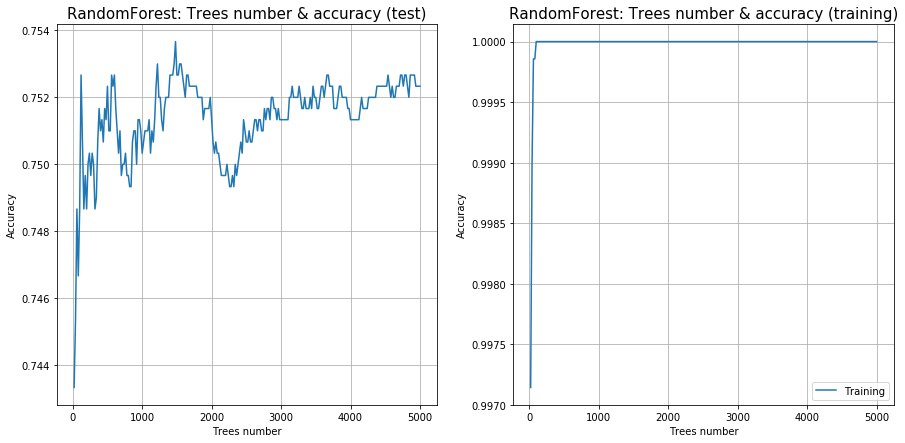

In [16]:
# чтобы более точно видеть все флуктуации кривой изменения качества
# построим 2 отдельных графика, чтобы получить небольшой масштаб, т.к значения могут сильно отличаться
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(np.arange(20, 5001, 20), accuracy_test_vect, label='Test')
plt.grid(True)
plt.xlabel('Trees number')
plt.ylabel('Accuracy')
plt.title('RandomForest: Trees number & accuracy (test)', size=15)


plt.subplot(1, 2, 2)
plt.plot(np.arange(20, 5001, 20), accuracy_train_vect, label='Training')
plt.grid(True)
plt.xlabel('Trees number')
plt.ylabel('Accuracy')
plt.title('RandomForest: Trees number & accuracy (training)', size=15)
plt.legend()

plt.show()

Довольно хорошо видно, что кривая на обучающей выборке выходит на асимптоту и достигает 1 практически сразу, в то время как на тестовой выборке она в то же время не превышает 0.755, что говорит о переобучении.

## Задача 6. Обучение градиентного бустинга

In [6]:
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV

# гайд по подору параметров был взят отсюда
# https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

# будем поэтапно проверять различные наборы параметров, подбирая лучшие
# для начала найдем оптимальные значения для n_estimators и learning_rate

params1 = {
    'n_estimators' : np.arange(30, 151, 20),
    'learning_rate' : np.linspace(0.1, 0.4, 7)
}

# объявим некоторый набор изначальных средних параметров
xgb = XGBClassifier(
    max_depth = 8,
    subsample = 0.8,
    min_child_weight = 1,
    colsample_bytree = 0.8,
    gamma=0,
    scale_pos_weight=1,
    n_jobs=-1
)

clf = GridSearchCV(xgb, param_grid=params1)
clf.fit(X_train, y_train)

best_params_1 = clf.best_params_

# установим найденные значения
xgb.set_params(**best_params_1)

print ('Best value for n_estimators - {}'.format(best_params_1['n_estimators']))
print ('Best value for learning_rate - {}'.format(best_params_1['learning_rate']))

Best value for n_estimators - 30
Best value for learning_rate - 0.1


In [18]:
# теперь протюним max_depth и min_child_weight
params2 = {
    'max_depth' : np.arange(3,10),
    'min_child_weight' : np.arange(1,8)
}

clf = GridSearchCV(xgb, param_grid=params2)
clf.fit(X_train, y_train)

best_params_2 = clf.best_params_

# снова установим новые значения
xgb.set_params(**best_params_2)

print ('Best value for max_depth - {}'.format(best_params_2['max_depth']))
print ('Best value for min_child_weight - {}'.format(best_params_2['min_child_weight']))

Best value for max_depth - 5
Best value for min_child_weight - 2


In [19]:
# тюним параметр gamma
params3 = {
    'gamma' : np.linspace(0, 0.4, 9)
}

clf = GridSearchCV(xgb, param_grid=params3)
clf.fit(X_train, y_train)

best_params_3 = clf.best_params_

# снова установим новые значения
xgb.set_params(**best_params_3)

print ('Best value for gamma - {}'.format(best_params_3['gamma']))

Best value for gamma - 0.0


In [20]:
# тюним параметры subsample и colsample_bytree
params4 = {
    'subsample' : np.linspace(0.6, 0.9, 7),
    'colsample_bytree' : np.linspace(0.6, 0.9, 7)
}

clf = GridSearchCV(xgb, param_grid=params4)
clf.fit(X_train, y_train)

best_params_4 = clf.best_params_

# снова установим новые значения
xgb.set_params(**best_params_4)

print ('Best value for subsample - {}'.format(best_params_4['subsample']))
print ('Best value for colsample_bytree - {}'.format(best_params_4['colsample_bytree']))

Best value for subsample - 0.8
Best value for colsample_bytree - 0.8


In [21]:
# тюним параметр регуляризации
params5 = {
    'reg_alpha' : np.logspace(-5, 2, 10)
}

clf = GridSearchCV(xgb, param_grid=params5)
clf.fit(X_train, y_train)

best_params_5 = clf.best_params_

# снова установим новые значения
xgb.set_params(**best_params_5)

print ('Best value for reg_alpha - {}'.format(best_params_5['reg_alpha']))

Best value for reg_alpha - 1e-05


In [22]:
from sklearn.metrics import roc_auc_score
# теперь уменьшим learning_rate и увеличим количество деревьев
xgb.set_params(learning_rate=0.01, n_estimators=1000)
# проверим итоговую точность после всех настроек
xgb.fit(X_train, y_train)
print ('Accuracy - {}'.format(xgb.score(X_test, y_test)))
print ('Roc-Auc - {}'.format(roc_auc_score(y_test, xgb.predict(X_test))))

Accuracy - 0.7533333333333333
Roc-Auc - 0.5444518056878227
